In [1]:
!pip install psycopg2-binary
!pip install geopy

In [27]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# 폰트 설정
mpl.rc('font', family='AppleGothic')  # macOS

# 마이너스 기호 깨짐 방지
mpl.rcParams['axes.unicode_minus'] = False

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
import psycopg2
from geopy.distance import geodesic
from itertools import combinations
from datetime import timedelta

In [7]:
# Seaborn 스타일 설정
sns.set_theme(style="whitegrid")

# ✅ PostgreSQL 연결 정보
DB_HOST = "14.34.134.108"   # DB ip 주소로 변경해야 함
DB_PORT = "5432"
DB_NAME = "ais_data"
DB_USER = "postgres"
DB_PASS = "ky76018500"

# 엔진 생성
engine = create_engine(f"postgresql://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}")

In [9]:
# ais_2020_03 테이블에서 샘플 데이터 30만 개 가져오기
query = """
SELECT * 
FROM ais_2020_03
limit 300000;
"""
df = pd.read_sql(query, engine)
print(df.columns)

# 시간 정렬 및 파싱
df['timestamp'] = pd.to_datetime(df['timestamp'])
df = df.sort_values(['mmsi', 'timestamp'])

# ✅ 위도(latitude)는 [-90, 90] 범위, 경도(longitude)는 [-180, 180] 범위로 필터링(이상치 처리)
df = df[(df["latitude"].between(-90, 90)) & (df["longitude"].between(-180, 180))]
df

Index(['mmsi', 'timestamp', 'latitude', 'longitude', 'sog', 'cog', 'heading'], dtype='object')


,mmsi,timestamp,latitude,longitude,sog,cog,heading
255288,/9dV9Ve5YD3fyZWl7IX/7A==,2020-03-01 00:00:28,34.896540,129.342960,11.1,218.5,217.0
255289,/9dV9Ve5YD3fyZWl7IX/7A==,2020-03-01 00:01:08,34.894882,129.341350,11.1,218.6,217.0
255290,/9dV9Ve5YD3fyZWl7IX/7A==,2020-03-01 00:01:18,34.894510,129.340990,11.1,218.6,217.0
255291,/9dV9Ve5YD3fyZWl7IX/7A==,2020-03-01 00:01:40,34.893604,129.340100,11.1,218.7,217.0
255292,/9dV9Ve5YD3fyZWl7IX/7A==,2020-03-01 00:01:48,34.893230,129.339740,11.1,218.7,217.0
...,...,...,...,...,...,...,...
200108,zftHFUd0Px8rABxzbRaeGw==,2020-03-01 23:46:57,34.899597,127.665630,0.0,246.0,234.0
200109,zftHFUd0Px8rABxzbRaeGw==,2020-03-01 23:49:56,34.899630,127.665695,0.0,246.0,234.0
200110,zftHFUd0Px8rABxzbRaeGw==,2020-03-01 23:52:56,34.899580,127.665670,0.0,246.0,234.0
200111,zftHFUd0Px8rABxzbRaeGw==,2020-03-01 23:55:57,34.899770,127.665760,0.1,246.0,234.0


In [11]:
# 근접 충돌 위험 탐지 함수 ( geodesic()은 조합비교기반이기 연산이 느리다)
def detect_collisions(df, threshold_km=0.5, interval='1min'):
    collisions = []

    # 시간 단위로 그룹핑
    df['timestamp_rounded'] = df['timestamp'].dt.floor(interval)
    grouped = df.groupby('timestamp_rounded')

    for time, group in grouped:
        vessels = group[['mmsi', 'latitude', 'longitude']].dropna()

        # MMSI 간 모든 조합 비교
        for (m1, lat1, lon1), (m2, lat2, lon2) in combinations(vessels.values, 2):
            dist = geodesic((lat1, lon1), (lat2, lon2)).km
            if dist < threshold_km:
                collisions.append({
                    'timestamp': time,
                    'mmsi_1': m1,
                    'mmsi_2': m2,
                    'distance_km': dist
                })

    return pd.DataFrame(collisions)

In [ ]:
# 충돌 위험 탐지 실행
collision_df = detect_collisions(df, threshold_km=0.5, interval='1min')

In [ ]:
# 충돌 지역 위치 시각화
plt.figure(figsize=(8, 6))
plt.scatter(df['longitude'], df['latitude'], s=1, alpha=0.2, label='전체 위치')
plt.scatter(
    collision_df.merge(df, left_on='mmsi_1', right_on='mmsi')['longitude'],
    collision_df.merge(df, left_on='mmsi_1', right_on='mmsi')['latitude'],
    color='red', s=10, label='충돌 위험'
)
plt.title("충돌 위험 위치 분포")
plt.xlabel("경도")
plt.ylabel("위도")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
#충돌 위험 지도 시각화 
! pip install folium

In [ ]:
import folium

# 1. 지도 생성 - 중심은 데이터 평균 위치로 설정
center_lat = df['latitude'].mean()
center_lon = df['longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=8, tiles='cartodb positron')

# 2. 전체 선박 위치 표시 (연한 점으로 표시)
for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=2,
        color='blue',
        fill=True,
        fill_opacity=0.2
    ).add_to(m)

# 3. 충돌 위험 지점 강조 표시 (붉은 원)
for _, row in collision_df.iterrows():
    mmsi_data = df[df['mmsi'] == row['mmsi_1']]
    nearest_time = mmsi_data.iloc[(mmsi_data['timestamp'] - row['timestamp']).abs().argsort()[:1]]
    
    for _, r in nearest_time.iterrows():
        folium.CircleMarker(
            location=[r['latitude'], r['longitude']],
            radius=6,
            color='red',
            fill=True,
            fill_opacity=0.8,
            popup=f"충돌 시각: {row['timestamp']}\nMMSI: {row['mmsi_1']} & {row['mmsi_2']}\n거리: {row['distance_km']:.3f} km"
        ).add_to(m)

# 4. HTML로 저장 or Jupyter에서 보기
m.save("collision_risk_map.html")
m  # Jupyter에서는 이렇게 하면 바로 표시됨

## 빠르게 충돌탐지 계산하기 위한 방법
	•	timestamp : 충돌 위험이 감지된 시각 (1분 단위)
	•	mmsi_1, mmsi_2 : 위험 근접에 있는 두 선박의 고유 ID
	•	distance_km : 두 선박 사이의 거리 (km). 기준 거리(threshold_km) 미만이면 충돌 위험으로 간주됨

In [11]:
from itertools import combinations

# 빠른 거리 계산용 haversine (단위: km)
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # 지구 반지름 (km)
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)

    a = np.sin(dphi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# 빠른 충돌 탐지 함수
def fast_detect_collisions(df, threshold_km=0.5, interval='1min', max_vessels=30):
    df['timestamp_rounded'] = df['timestamp'].dt.floor(interval)
    grouped = df.groupby('timestamp_rounded')
    collisions = []

    for time, group in grouped:
        group = group[['mmsi', 'latitude', 'longitude']].dropna()

        if len(group) > max_vessels:
            continue  # 계산량 줄이기

        vessel_list = group.values

        for (m1, lat1, lon1), (m2, lat2, lon2) in combinations(vessel_list, 2):
            if m1 == m2:
                continue  # 같은 선박 비교하 않도록

            dist = haversine_distance(lat1, lon1, lat2, lon2)
            if dist < threshold_km:
                collisions.append({
                    'timestamp': time,
                    'mmsi_1': m1,
                    'mmsi_2': m2,
                    'distance_km': round(dist, 4)
                })

    return pd.DataFrame(collisions)

In [13]:
df['timestamp_rounded'] = df['timestamp'].dt.floor('5min')
print(df.groupby('timestamp_rounded')['mmsi'].nunique().describe())

count    288.000000
mean      68.152778
std        3.775622
min       59.000000
25%       65.000000
50%       68.000000
75%       71.000000
max       78.000000
Name: mmsi, dtype: float64


In [15]:
collision_df = fast_detect_collisions(df, threshold_km=1.0, interval='1min', max_vessels=300)
print("탐지된 충돌 위험 수:", len(collision_df))
collision_df.head()

탐지된 충돌 위험 수: 6439


,timestamp,mmsi_1,mmsi_2,distance_km
0,2020-03-01 00:02:00,MoPhFMy0l+kEYd5JSPXi+Q==,aBA6Ln+vOjecHsEtYcMdxA==,0.3223
1,2020-03-01 00:02:00,MoPhFMy0l+kEYd5JSPXi+Q==,aBA6Ln+vOjecHsEtYcMdxA==,0.3223
2,2020-03-01 00:02:00,MoPhFMy0l+kEYd5JSPXi+Q==,aBA6Ln+vOjecHsEtYcMdxA==,0.3223
3,2020-03-01 00:02:00,MoPhFMy0l+kEYd5JSPXi+Q==,aBA6Ln+vOjecHsEtYcMdxA==,0.3219
4,2020-03-01 00:02:00,MoPhFMy0l+kEYd5JSPXi+Q==,aBA6Ln+vOjecHsEtYcMdxA==,0.3219


In [17]:
df['mmsi'].nunique()  # 데이터 내 선박 수

112

In [19]:
print(df.shape)
print(df[['mmsi', 'timestamp', 'latitude', 'longitude']].isnull().sum())
print(df['timestamp'].min(), df['timestamp'].max())

(296659, 8)
mmsi         0
timestamp    0
latitude     0
longitude    0
dtype: int64
2020-03-01 00:00:00 2020-03-01 23:59:59


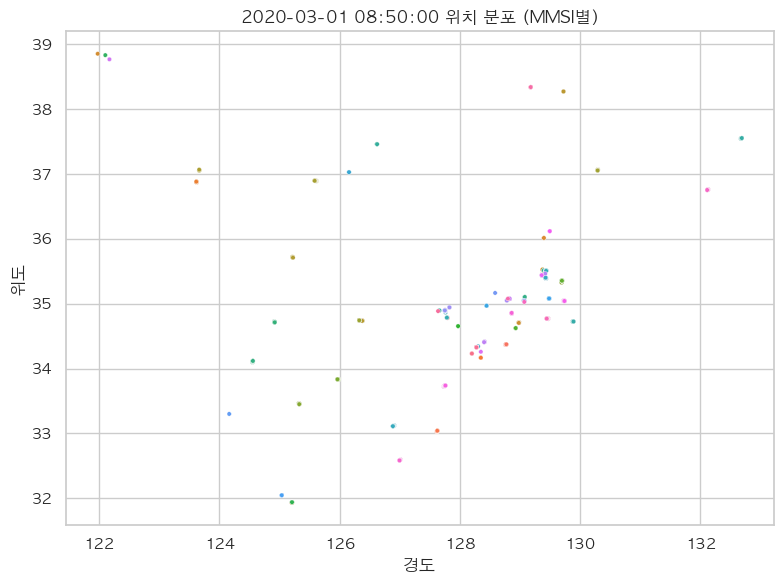

In [29]:
# 1. 선박 수 가장 많은 시간대
df['timestamp_rounded'] = df['timestamp'].dt.floor('5min')
top_time = df.groupby('timestamp_rounded')['mmsi'].nunique().sort_values(ascending=False).index[0]

# 2. 해당 시간대 데이터 추출
sample = df[df['timestamp_rounded'] == top_time]

# 3. 위치 분포 시각화
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(data=sample, x='longitude', y='latitude', hue='mmsi', s=10, palette='husl',legend=False)
plt.title(f"{top_time} 위치 분포 (MMSI별)")
plt.xlabel("경도")
plt.ylabel("위도")
plt.grid(True)
plt.tight_layout()
plt.show()

In [31]:
# 가까운 선박끼리 거리 수동 측정해보기 (검증) 
from geopy.distance import geodesic
from itertools import combinations
import pandas as pd

pairs = []

# 같은 시간대 데이터에서 같은 MMSI 여러 개 있는지 확인 후 처리
sample_filtered = (
    sample.sort_values('timestamp')  # 시간순 정렬
    .drop_duplicates(subset=['timestamp_rounded', 'mmsi'], keep='last')  # 중복 제거
)
# 거리 계산
for (i1, row1), (i2, row2) in combinations(sample.iterrows(), 2):
    if row1['mmsi'] == row2['mmsi']:
        continue  # 같은 선박은 건너뛰기

    dist = geodesic(
        (row1['latitude'], row1['longitude']),
        (row2['latitude'], row2['longitude'])
    ).km

    if dist < 2.0:
        mmsi_1, mmsi_2 = sorted([row1['mmsi'], row2['mmsi']])
        
        pairs.append({
            'timestamp': row1['timestamp'],
            'mmsi_1': mmsi_1,
            'mmsi_2': mmsi_2,
            'dist_km': round(dist, 4)
        })

# DataFrame 생성
df_close_pairs = pd.DataFrame(pairs)

# 중복 제거 (같은 시간, 같은 쌍은 하나만 유지)
df_close_pairs = df_close_pairs.sort_values('dist_km')
df_close_pairs = df_close_pairs.drop_duplicates(subset=['timestamp', 'mmsi_1', 'mmsi_2'], keep='first')

# 결과 출력
display(df_close_pairs.head(10))

,timestamp,mmsi_1,mmsi_2,dist_km
113,2020-03-01 08:52:54,QoJ28blheM4pB1jqLoZsCQ==,mbB1DScfaHGO1Sy6Xus6Jg==,0.1846
127,2020-03-01 08:50:24,TfRgVR//6EnpAhnKrkfpEQ==,VhP7gUbcTy8Ylc9o45Rljw==,0.2838
128,2020-03-01 08:53:24,TfRgVR//6EnpAhnKrkfpEQ==,VhP7gUbcTy8Ylc9o45Rljw==,0.2883
87,2020-03-01 08:50:04,MoPhFMy0l+kEYd5JSPXi+Q==,aBA6Ln+vOjecHsEtYcMdxA==,0.3177
187,2020-03-01 08:51:07,Z+54Xwy5WD7b6pPZhxCSkQ==,eENSRcIxhYmJEtCzif4tCg==,0.3956
169,2020-03-01 08:53:39,U3eQ5jz2RPf+ECc5+/1OTg==,rPgAj+6DYgxHq2yie+zZFA==,0.6296
173,2020-03-01 08:53:58,U3eQ5jz2RPf+ECc5+/1OTg==,rPgAj+6DYgxHq2yie+zZFA==,0.6302
171,2020-03-01 08:53:48,U3eQ5jz2RPf+ECc5+/1OTg==,rPgAj+6DYgxHq2yie+zZFA==,0.6302
153,2020-03-01 08:52:19,U3eQ5jz2RPf+ECc5+/1OTg==,rPgAj+6DYgxHq2yie+zZFA==,0.6303
175,2020-03-01 08:54:09,U3eQ5jz2RPf+ECc5+/1OTg==,rPgAj+6DYgxHq2yie+zZFA==,0.6304
